In [585]:
#Подгрузим необходимые библиотеки
import pandas as pd
import numpy as np
import ast
from numpy import nan
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import tqdm
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.snowball import SnowballStemmer
import pymorphy2
from scipy import stats

%matplotlib inline
sns.set_theme()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Первичная предобработка данных

Работать будем с датасетом по группам вконтакте.

In [586]:
group_data = pd.read_excel(r'C:\Users\User\Desktop\Прога\Питон\аналитика вк\парсинг вк\group_data.xlsx')

In [587]:
group_data.head()

,Unnamed: 0,id,from_id,owner_id,date,marked_as_ads,post_type,text,attachments,post_source,comments,likes,reposts,group_id,copy_history,signer_id,copyright,is_pinned
0,0,16534261,-29573241,-29573241,1622387628,0,post,[club29573241|Soulja Boy] хочет стать первым р...,"[{'type': 'photo', 'photo': {'album_id': -7, '...",{'type': 'vk'},"{'count': 45, 'can_post': 1}","{'count': 610, 'user_likes': 0, 'can_like': 1,...","{'count': 106, 'user_reposted': 0}",-29573241,NaN,NaN,NaN,NaN
1,1,16534178,-29573241,-29573241,1622385900,0,post,[club29573241|Billie EIlish] для бренда Nike 👱...,"[{'type': 'photo', 'photo': {'album_id': -7, '...",{'type': 'vk'},"{'count': 32, 'can_post': 1}","{'count': 1265, 'user_likes': 0, 'can_like': 1...","{'count': 90, 'user_reposted': 0}",-29573241,NaN,NaN,NaN,NaN
2,2,16534104,-29573241,-29573241,1622384885,0,post,[club92741129|KIZARU] выложил текст своего гря...,"[{'type': 'photo', 'photo': {'album_id': -7, '...",{'type': 'vk'},"{'count': 203, 'can_post': 1}","{'count': 753, 'user_likes': 0, 'can_like': 1,...","{'count': 390, 'user_reposted': 0}",-29573241,NaN,NaN,NaN,NaN
3,3,16534010,-29573241,-29573241,1622381700,0,post,"[club37759946|playingtheangel] — ""хочу тебя юз...","[{'type': 'photo', 'photo': {'album_id': -7, '...",{'type': 'vk'},"{'count': 22, 'can_post': 1}","{'count': 472, 'user_likes': 0, 'can_like': 1,...","{'count': 223, 'user_reposted': 0}",-29573241,NaN,NaN,NaN,NaN
4,4,16533938,-29573241,-29573241,1622380200,0,post,[club123675921|MORGENSHTERN] в первый раз сним...,"[{'type': 'video', 'video': {'access_key': '76...",{'type': 'vk'},"{'count': 29, 'can_post': 1}","{'count': 541, 'user_likes': 0, 'can_like': 1,...","{'count': 252, 'user_reposted': 0}",-29573241,NaN,NaN,NaN,NaN


Приведем колонки с лайками, репостами и помментариями в нормальный вид, для этого достанем из каждого словаря их количество

In [588]:
group_data['likes'] = group_data['likes'].apply(lambda x: ast.literal_eval(x)['count'])
group_data['post_source'] = group_data['post_source'].apply(lambda x: ast.literal_eval(x)['type'])
group_data['comments'] = group_data['comments'].apply(lambda x: ast.literal_eval(x)['count'])
group_data['reposts'] = group_data['reposts'].apply(lambda x: ast.literal_eval(x)['count'])

Столбцы с copy_history, signer_id, attachments не несут никакой ценности, поэтому удалим их

In [589]:
group_data = group_data.drop(columns=['Unnamed: 0', 'from_id', 'group_id', 'copy_history', 'signer_id', 'attachments'])

Создадим датафрейм с названиями групп по каждому индексу и присоединим их к нашему исходному датафрейму. Соединять будем по колонке owner_id, используя left join

In [590]:
group_ids = [-65596623, -57846937, -150550417, -28905875, -73247559, -66678575, -31480508, -88245281, -29573241]
group_names = ['FTP', 'MDK', 'Reddit', 'Рифмы и панчи', 'ВПШ', 'Овсянка', 'Пикабу', 'На приеме у шевцова', 'NR']
group_names_df = pd.DataFrame({'owner_id':group_ids, 'group_names':group_names})

In [591]:
group_data = group_data.merge(group_names_df, on='owner_id', how='left')

Преобразуем таймстемп в нормальную дату и время, затем создадим колонки с датой, временем и днем недели для дальнейшего анализа

In [592]:
group_data['date'] = [datetime.fromtimestamp(x) for x in group_data['date']]
group_data['day'] = group_data['date'].dt.date
group_data['hour'] = group_data['date'].dt.hour
group_data['day_of_week'] = group_data['date'].dt.weekday

In [593]:
group_data.head()

,id,owner_id,date,marked_as_ads,post_type,text,post_source,comments,likes,reposts,copyright,is_pinned,group_names,day,hour,day_of_week
0,16534261,-29573241,2021-05-30 20:13:48,0,post,[club29573241|Soulja Boy] хочет стать первым р...,vk,45,610,106,NaN,NaN,NR,2021-05-30,20,6
1,16534178,-29573241,2021-05-30 19:45:00,0,post,[club29573241|Billie EIlish] для бренда Nike 👱...,vk,32,1265,90,NaN,NaN,NR,2021-05-30,19,6
2,16534104,-29573241,2021-05-30 19:28:05,0,post,[club92741129|KIZARU] выложил текст своего гря...,vk,203,753,390,NaN,NaN,NR,2021-05-30,19,6
3,16534010,-29573241,2021-05-30 18:35:00,0,post,"[club37759946|playingtheangel] — ""хочу тебя юз...",vk,22,472,223,NaN,NaN,NR,2021-05-30,18,6
4,16533938,-29573241,2021-05-30 18:10:00,0,post,[club123675921|MORGENSHTERN] в первый раз сним...,vk,29,541,252,NaN,NaN,NR,2021-05-30,18,6


# Обработка текста в посте

Напишем несколько функций.
Первая удаляет в тексте ненужные символы и стоп слова, приводит все к нижнему регистру.

Вторая производит стеминг, то есть приводит слова к своей основе. В данном ноутбуке она использоваться не будет, так как пострадает интерпретируемость в дальнейшей визуализации.

Также сделаем лемматизацию кажого слова.

In [594]:
def preprocessing_text(texts):
    my_words = set({'это', "который", "комментарий", "новый", "год"})
    eng = set(stopwords.words('english'))
    rus = set(stopwords.words('russian'))
    stop = eng | rus | my_words
    
    regex = re.compile('[^а-яА-Я]')
    preprocess_texts = []
    for i in  tqdm.tqdm(range(len(texts))):
        text = texts[i].lower()
        text = regex.sub(' ', text)
        word_tokens = word_tokenize(text)
        filtered_str = [w for w in word_tokens if not w in stop] 
        preprocess_texts.append( ' '.join(filtered_str))
    
    return preprocess_texts
        


In [595]:
def text_stem(texts):
    st = SnowballStemmer("russian")
    stem_text = []
    for text in tqdm.tqdm(texts):
        tokenised_text = word_tokenize(text)
        stem_text.append(' '.join([st.stem(word) for word in tokenised_text]))
    return stem_text

In [596]:
def text_lem(texts):
    lem = pymorphy2.MorphAnalyzer()
    lem_text = []
    for text in tqdm.tqdm(texts):
        tokenised_text = word_tokenize(text)
        lem_text.append(' '.join([lem.parse(word)[0].normal_form for word in tokenised_text]))
    return lem_text

Применим функции к описанию каждого поста

In [597]:
group_data['text'].fillna('', inplace=True)
group_data['text'] = preprocessing_text(group_data['text'])
group_data['text'] = text_lem(group_data['text'])
group_data['text'] = preprocessing_text(group_data['text'])

100%|██████████| 9000/9000 [00:01<00:00, 7250.85it/s]


Построим word cloud для обнаружения самых часто встречающихся слов.

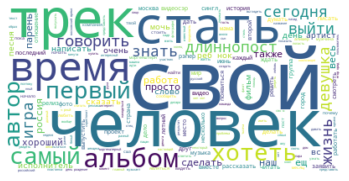

In [598]:
text = " ".join(desc for desc in group_data.text)
wordcloud = WordCloud(background_color="white").generate(text)


plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Можно заметить, что оно получилось абсолютно неинтерпретабельно, поэтому построим облако отдельно по каждой группе.

In [599]:
df = group_data.groupby('group_names')['text'].agg(lambda x: ' '.join(x))

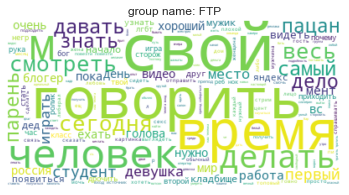

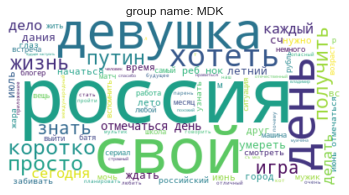

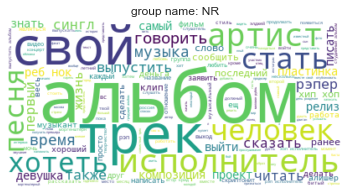

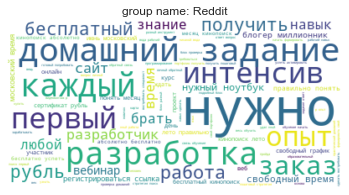

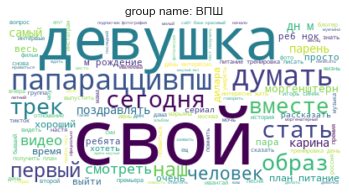

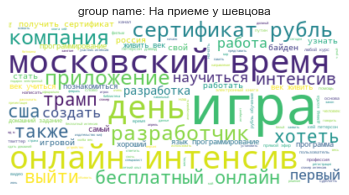

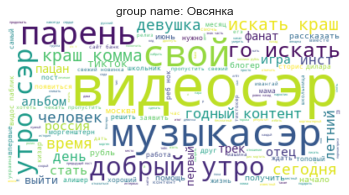

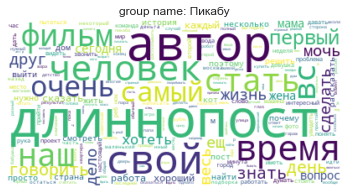

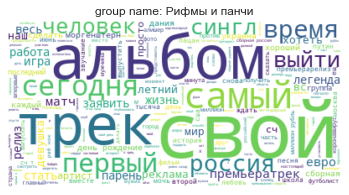

In [600]:
for group, text in df.items():
    wordcloud = WordCloud(background_color="white").generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title('group name: {}'.format(group))
    plt.show()

In [601]:
group_data.head(2)

,id,owner_id,date,marked_as_ads,post_type,text,post_source,comments,likes,reposts,copyright,is_pinned,group_names,day,hour,day_of_week
0,16534261,-29573241,2021-05-30 20:13:48,0,post,хотеть стать первый рэпер побывать космос рэпе...,vk,45,610,106,NaN,NaN,NR,2021-05-30,20,6
1,16534178,-29573241,2021-05-30 19:45:00,0,post,бренд,vk,32,1265,90,NaN,NaN,NR,2021-05-30,19,6


Избавимся от выбросов и пропущеных значений в данных. 
Для этого используем правило трех сигм, с помощью которого будут удалены значения, выходящие за 99% квантиль.

Также удалим наблюдение, в котором post_source = mvk, так как оно всего одно и в дальнейшем не будет играть никакой роли

In [602]:
group_data.fillna(0, inplace=True)
group_data = group_data[group_data['post_source'] != 'mvk']
group_data = group_data[(np.abs(stats.zscore(group_data[['comments', 'likes', 'reposts']])) < 3).all(axis=1)]

Посмотрим, как отличаются основные показатели поста в зависимости от типа ресурса и группы публикации

In [603]:
group_data.groupby('post_source')['likes', 'reposts', 'comments'].agg(['count', 'mean', 'median'])

<ipython-input-603-0db58a4e5012>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  group_data.groupby('post_source')['likes', 'reposts', 'comments'].agg(['count', 'mean', 'median'])


likes                      reposts                     comments  \
            count          mean median   count         mean median    count   
post_source                                                                   
api          2633  10549.292442   7865    2633  1292.907710    711     2633   
vk           5981   3938.400769   2468    5981  1049.851697    579     5981   

                                
                   mean median  
post_source                     
api          234.746297    162  
vk            99.213509     50

In [604]:
group_data.groupby('group_names')['likes'].agg(['count', 'mean', 'median']).sort_values(by='mean', ascending=False)

,count,mean,median
group_names,,,
На приеме у шевцова,934,16206.882227,16542.0
ВПШ,830,13418.583133,12973.0
Рифмы и панчи,960,6939.776042,5853.0
Овсянка,942,5927.000000,5085.0
Reddit,1000,4352.589000,3484.0
MDK,955,3505.221990,2815.0
Пикабу,998,2593.611222,2610.5
NR,998,1301.806613,1005.0
FTP,997,1227.771314,826.0


C:\Users\User\anaconda3\lib\site-packages\seaborn\axisgrid.py:643: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


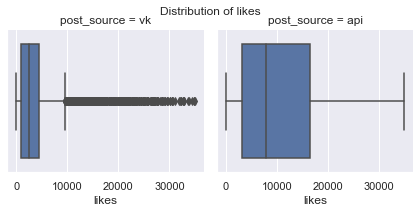

In [605]:
g = sns.FacetGrid(group_data, col="post_source");
g.map(sns.boxplot, 'likes');

g.fig.suptitle('Distribution of likes', fontsize=12);

C:\Users\User\anaconda3\lib\site-packages\seaborn\axisgrid.py:643: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


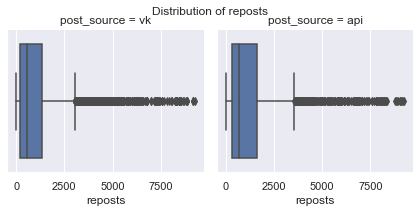

In [606]:
g = sns.FacetGrid(group_data, col="post_source");
g.map(sns.boxplot, 'reposts');
g.fig.suptitle('Distribution of reposts', fontsize=12);

C:\Users\User\anaconda3\lib\site-packages\seaborn\axisgrid.py:643: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


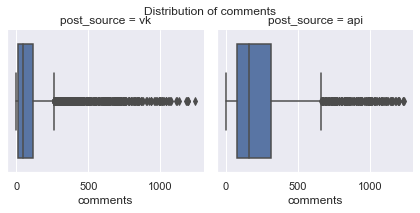

In [607]:
g = sns.FacetGrid(group_data, col="post_source");
g.map(sns.boxplot, 'comments');
g.fig.suptitle('Distribution of comments', fontsize=12);

Можем заметить, что у записей, опубликованных через api показатели выше. Полагаю, что более популярные паблики в основном заливают посты через api

In [608]:
group_data.groupby(['post_source', 'group_names'])['likes'].agg(['count', 'mean', 'median']).sort_values(by='mean', ascending=False)

count          mean   median
post_source group_names                                      
api         На приеме у шевцова    486  18351.452675  18311.5
            ВПШ                    755  14468.618543  14316.0
vk          На приеме у шевцова    448  13880.406250  14340.5
api         Рифмы и панчи          298   7210.902685   6247.0
            Овсянка                755   7049.953642   6106.0
vk          Рифмы и панчи          662   6817.728097   5762.0
api         Reddit                   9   4958.888889   4193.0
vk          Reddit                 991   4347.082745   3479.0
            MDK                    862   3537.120650   2878.5
api         Пикабу                   5   3502.200000   2619.0
            MDK                     93   3209.559140   2283.0
vk          ВПШ                     75   2848.226667    391.0
            Пикабу                 993   2589.036254   2609.0
            FTP                    765   1467.461438   1069.0
            Овсянка                187   1393.149733    576.0
            NR                     998   1301.806613   1005.0
api         FTP                    232    437.413793    281.5

Так и есть, скорее всего все портит паблик ВПШ, который в основном заливает посты через api, лайки на которых значительно выше, построим графики без него

C:\Users\User\anaconda3\lib\site-packages\seaborn\axisgrid.py:643: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


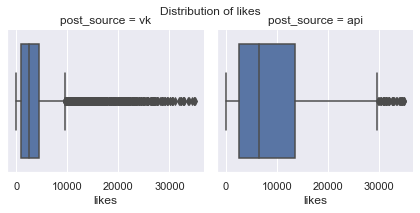

In [609]:
g = sns.FacetGrid(group_data[group_data['group_names'] != 'ВПШ'], col="post_source");
g.map(sns.boxplot, 'likes');
g.fig.suptitle('Distribution of likes', fontsize=12);

В графиках мало что поменялось, проверим гипотезу о равенстве средних на уровне значимости 5%.
Наблюдений много, поэтому воспользуемся асимптотикой

In [610]:
vk = group_data[(group_data['post_source'] == 'vk') & (group_data['group_names'] != 'ВПШ')]['likes']
api = group_data[(group_data['post_source'] == 'api') & (group_data['group_names'] != 'ВПШ')]['likes']

In [611]:
alpha = 0.05
nu1 = vk.mean()
nu2 = api.mean()
diff = nu2 - nu1
std1 = vk.var(ddof=1)
std2 = api.var(ddof=1)
z_obs = diff / np.sqrt(std1/vk.size + std2/api.size)
z_crit = stats.norm().ppf(1-alpha/2)
p_value = 2* (1 - (stats.norm().cdf(z_obs)))
print('z_obs:{}, z_crit:{}, p_value:{}'.format(z_obs, z_crit, p_value))

z_obs:25.467645192048515, z_crit:1.959963984540054, p_value:0.0


Наблюдаемое значение статистики получилось очень большим, поэтому гипотезу о равенстве средних отвергаем.

# Визуализация данных

Исследуем основные зависимости. 
Интересно узнать, когда в основном выкладывают рекламные посты, для этого создадим сгруппированный датафрейм по времени выхода поста

In [612]:
ad_by_h = group_data.groupby(['marked_as_ads', 'hour'])['likes'].agg('count')
state_pcts = ad_by_h.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))
state_pcts1 = pd.DataFrame(state_pcts).reset_index()


C:\Users\User\anaconda3\lib\site-packages\seaborn\axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


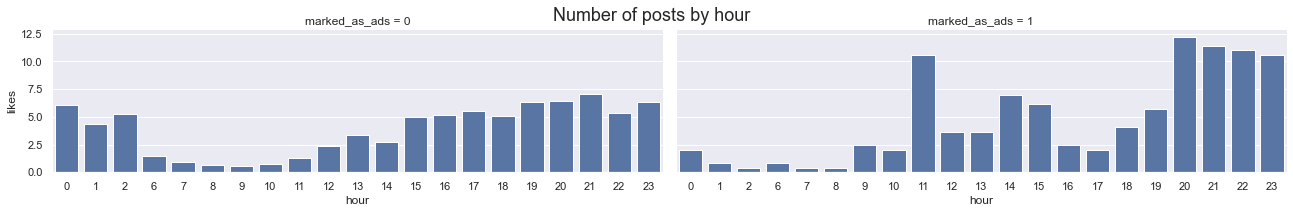

In [613]:
g = sns.FacetGrid(state_pcts1, col="marked_as_ads", aspect=3);
g.map(sns.barplot, 'hour', 'likes');
g.fig.suptitle('Number of posts by hour', fontsize=18);

Узнаем лучшее время публикации для набора лайков

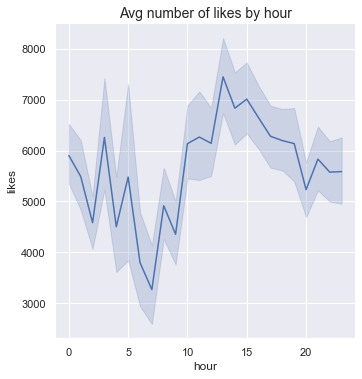

In [614]:
sns.relplot(data=group_data, x='hour', y='likes', kind='line')
plt.title('Avg number of likes by hour', fontsize=14);

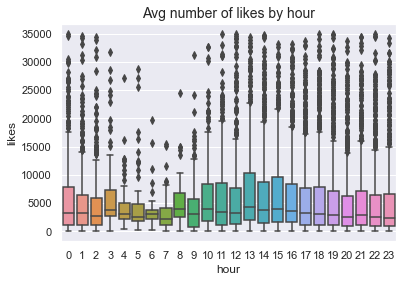

In [615]:
sns.boxplot(data=group_data, x='hour', y='likes')
plt.title('Avg number of likes by hour', fontsize=14);

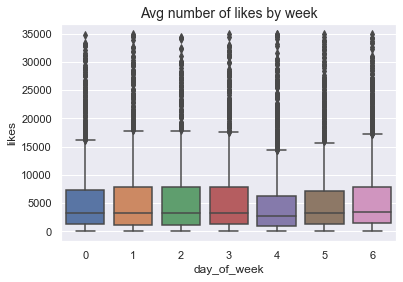

In [616]:
sns.boxplot(data=group_data, x='day_of_week', y='likes')
plt.title('Avg number of likes by week', fontsize=14);

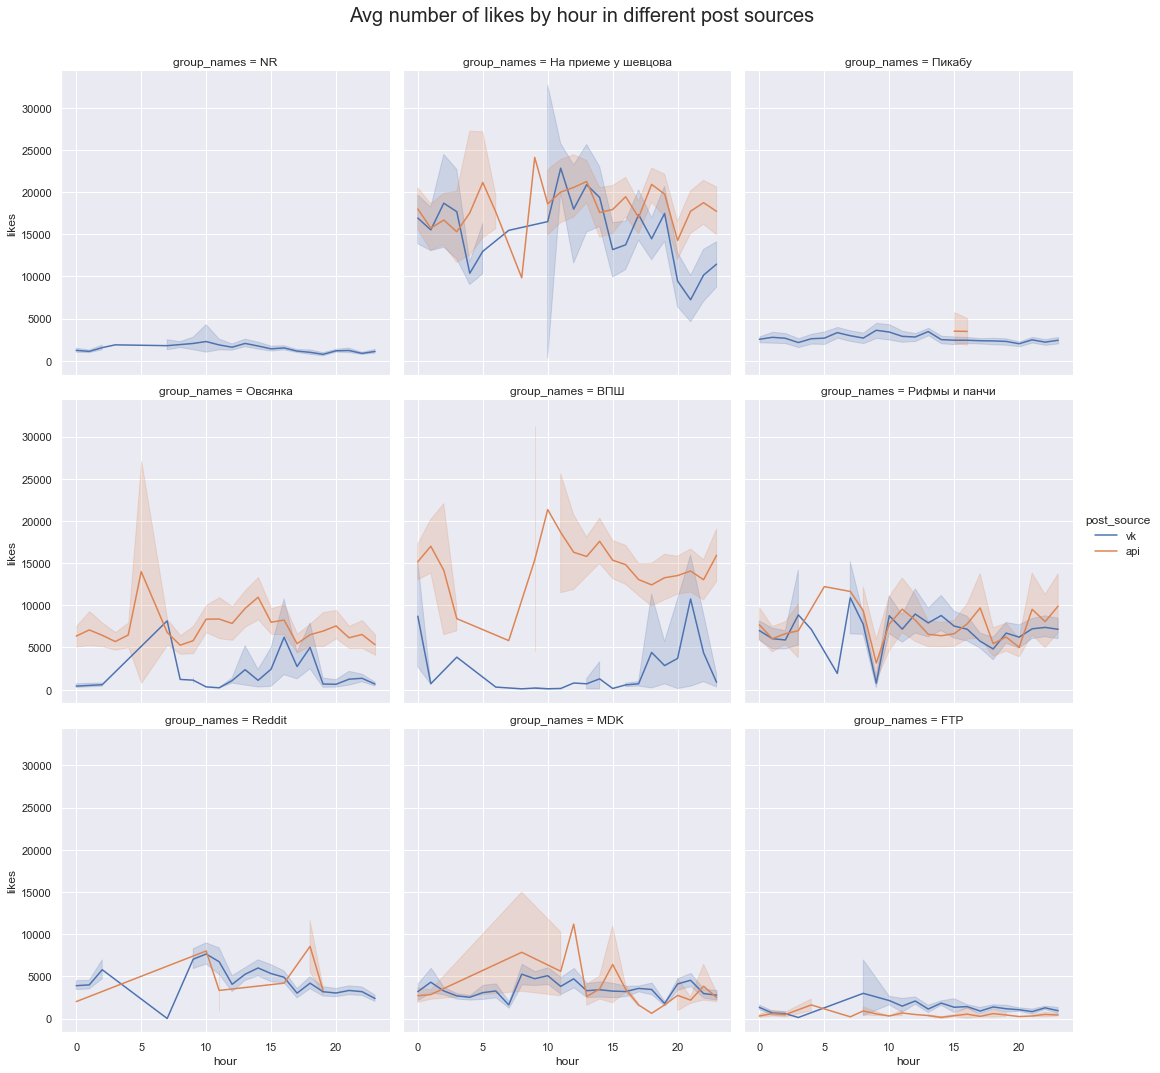

In [617]:
rp = sns.relplot(data=group_data, x="hour", y="likes", hue="post_source", kind='line', col='group_names', col_wrap=3)
rp.fig.subplots_adjust(top=0.92)
rp.fig.suptitle('Avg number of likes by hour in different post sources', fontsize=20);

Построим распределение лайков по каждому паблику.
Похоже, что распределения у пабликов На приеме у шевцова и ВПШ похожи на нормальные. Остальные, по видимому распределены экспоненциально.

C:\Users\User\anaconda3\lib\site-packages\seaborn\axisgrid.py:643: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


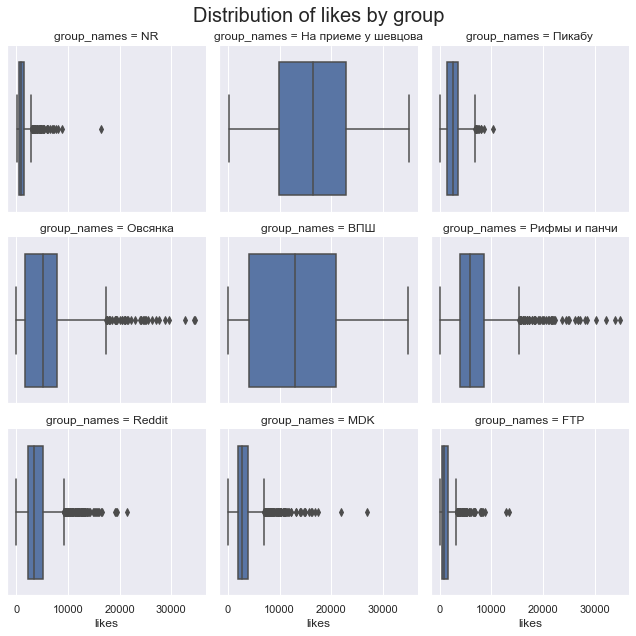

In [618]:
g = sns.FacetGrid(group_data, col="group_names", col_wrap=3);
g.map(sns.boxplot, 'likes');
g.fig.subplots_adjust(top=0.92)
g.fig.suptitle('Distribution of likes by group', fontsize=20);

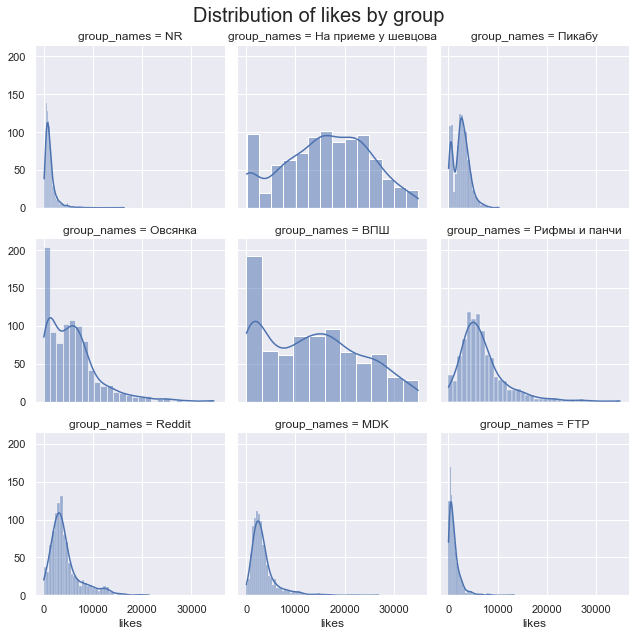

In [619]:
g = sns.FacetGrid(group_data, col="group_names", col_wrap=3);
g.map(sns.histplot, 'likes', kde=True);
g.fig.subplots_adjust(top=0.92)
g.fig.suptitle('Distribution of likes by group', fontsize=20);

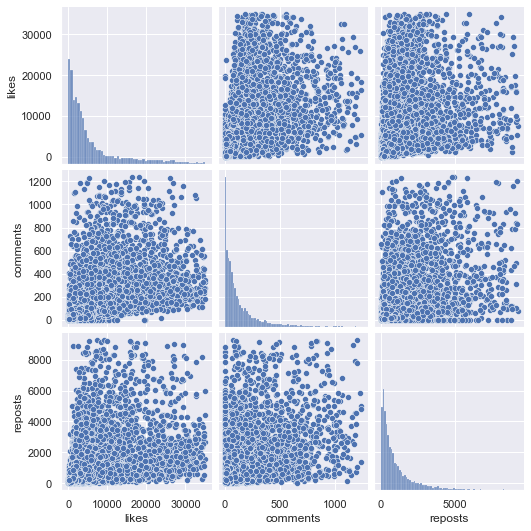

In [620]:
sns.pairplot(group_data[['likes', 'comments', 'reposts']])

Создадим новую переменную с количеством букв в описании и посмотрим, как коррелируют между собой лайки, комментарии, репосты и наши новые переменные.

In [621]:
group_data['word_num_desc'] = group_data['text'].apply(lambda x: len(x.split()))

In [622]:
group_data.word_num_desc.describe()

count    8614.000000
mean        9.423148
std        19.571755
min         0.000000
25%         0.000000
50%         2.000000
75%        10.000000
max       388.000000
Name: word_num_desc, dtype: float64

<AxesSubplot:>

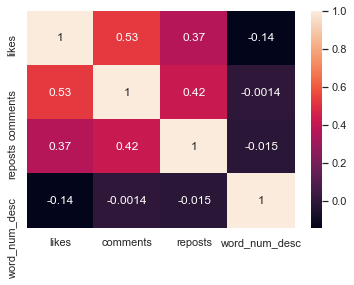

In [623]:
sns.heatmap(group_data[['likes', 'comments', 'reposts', 'word_num_desc']].corr(), annot=True)

Видно небольшую мультиколлинеарность между репостами и комментариям